In [13]:
import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from argparse import Namespace
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingClassifier
'''Definition'''

MAGNITUDE = True
SEED = 0
np.random.seed(SEED)
pca_2d = PCA(n_components=2)
scaler = StandardScaler() 
def load_data(data_dir, return_mag=True):
    data = scipy.io.loadmat(data_dir)
    d, t,r = data['data'], data['target'],data['gases_ratios']
    r = r[:, -1].reshape(-1, 1)
    if return_mag:
        d = np.abs(d)
    else:
        dreal = np.real(d)
        dimg = np.imag(d)
        d = np.concatenate([dreal, dimg], axis=1)
    return d.astype(np.float32), t.astype(np.float32),r.astype(np.float32)




In [14]:
ALL_TRAIN_X = []
ALL_TRAIN_Y = []
ALL_TEST_X = []
ALL_TEST_Y = []
ACCORDING_DISTANCES = []
for i in range(0,51,10):
    if i<10:
        DATA_DIR_i = f"1000_SNR_100/SNR_{1}.mat"
    else:
        DATA_DIR_i = f"1000_SNR_100/SNR_{i}.mat"
    ACCORDING_DISTANCES.append(Namespace(**scipy.io.loadmat(DATA_DIR_i)).distance)
    f, l,r = load_data(DATA_DIR_i, MAGNITUDE)
    ALL_TRAIN_X.append(f)  
    ALL_TRAIN_Y.append(l)
    ALL_TEST_X.append(f)
    ALL_TEST_Y.append(l)
ACCORDING_DISTANCES =[int(np.mean(i)) for i in ACCORDING_DISTANCES]
print(ACCORDING_DISTANCES)
ALL_TEST_X = np.array(ALL_TEST_X)
ALL_TEST_Y = np.array(ALL_TEST_Y)
ALL_TRAIN_X = np.array(ALL_TRAIN_X)
ALL_TRAIN_Y = np.array(ALL_TRAIN_Y)
print(ALL_TRAIN_X.shape)
print(ALL_TRAIN_Y.shape)
print(ALL_TEST_X.shape)
print(ALL_TEST_Y.shape)

[1, 10, 20, 30, 40, 50]
(6, 2000, 256)
(6, 2000, 1)
(6, 2000, 256)
(6, 2000, 1)


In [17]:
RES = [] # expected to be of dimensions (6,100)
ALL_X_CUM = np.empty((0, ALL_TRAIN_X[0].shape[1]))
ALL_Y_CUM = np.empty((0, ALL_TRAIN_Y[0].shape[1]))
for i in range(0,6):
    if ALL_X_CUM.size == 0: 
        ALL_X_CUM = ALL_TRAIN_X[i] 
    else:
        ALL_X_CUM = np.concatenate((ALL_X_CUM, ALL_TRAIN_X[i]), axis=0)  
    if ALL_Y_CUM.size == 0:
        ALL_Y_CUM = ALL_TRAIN_Y[i]
    else:
        ALL_Y_CUM = np.concatenate((ALL_Y_CUM, ALL_TRAIN_Y[i]), axis=0)

    X_train = ALL_X_CUM
    y_train = ALL_Y_CUM.squeeze()
    # X_train = ALL_TRAIN_X[i]
    # y_train = ALL_TRAIN_Y[i].squeeze()
    X_train_sc = scaler.fit_transform(X_train)
    X_train_sc_pca_2 = pca_2d.fit_transform(X_train_sc)
    LOG_2 = LogisticRegression()
    LOG_2.fit(X_train_sc_pca_2, y_train) 
    test_i_res = []
    for j in range(0,6):
        X_test = ALL_TEST_X[j]
        y_test = ALL_TEST_Y[j].squeeze()
        X_test_sc = scaler.transform(X_test)
        X_test_sc_pca_2 = pca_2d.transform(X_test_sc)
        acc_test_LOG_2 = accuracy_score(y_test, LOG_2.predict(X_test_sc_pca_2))
        test_i_res.append(acc_test_LOG_2)
    RES.append(test_i_res)

Actual Drawings!

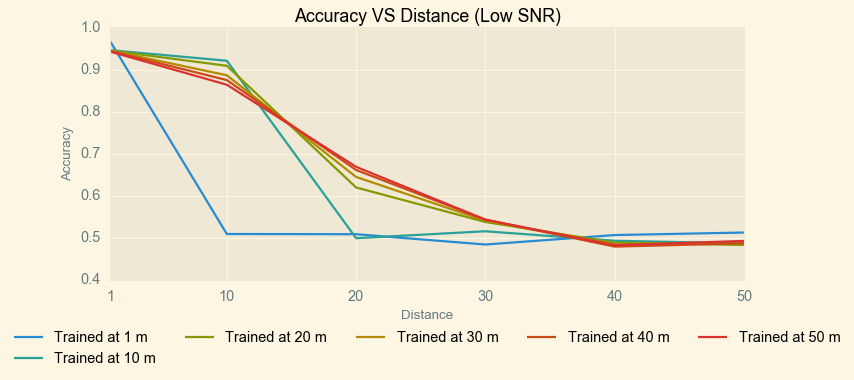

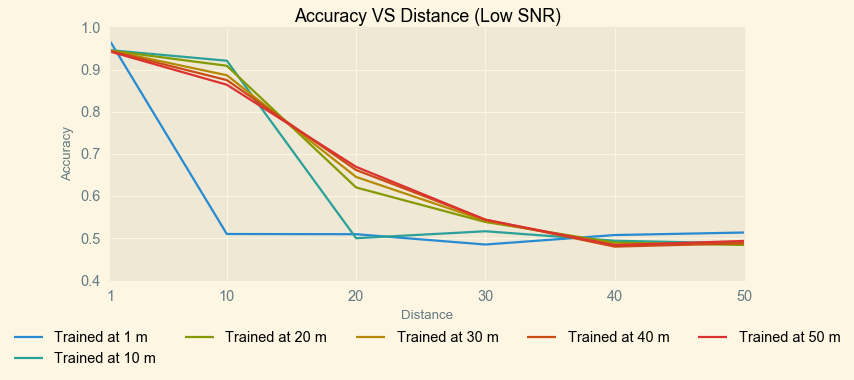

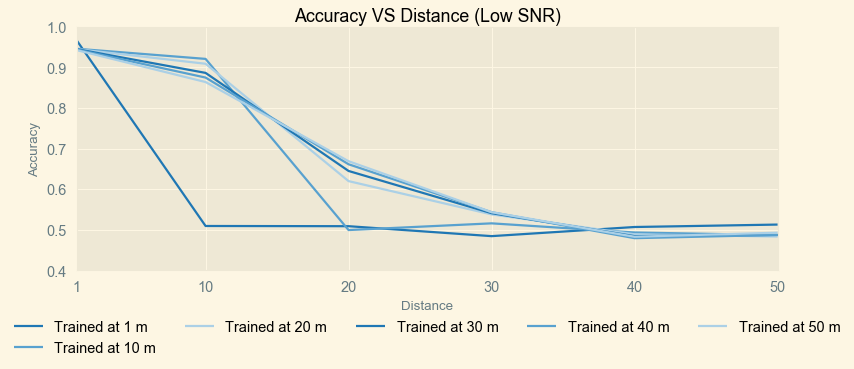

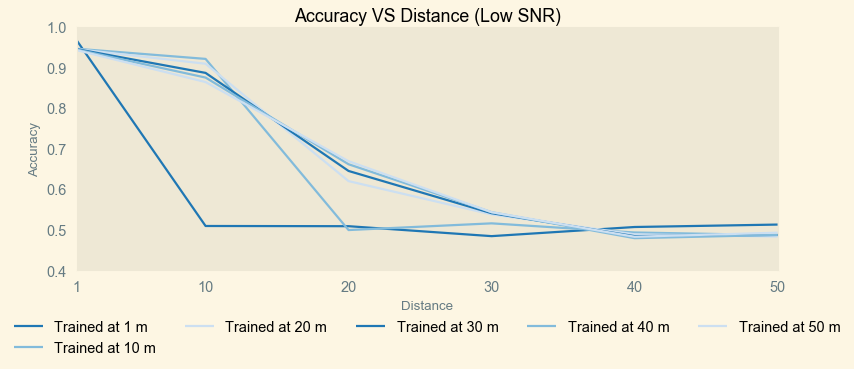

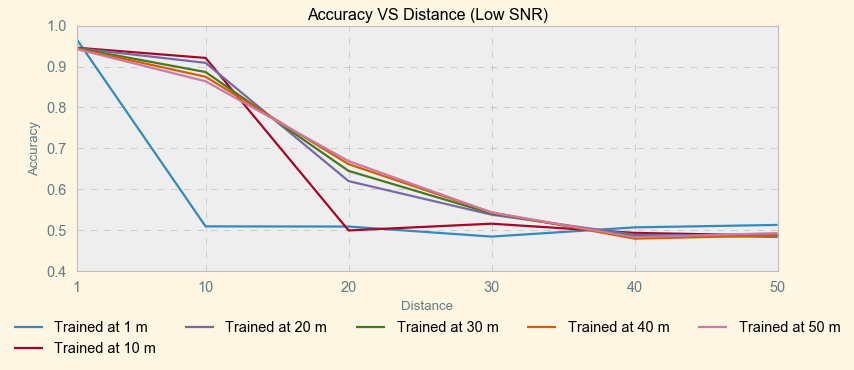

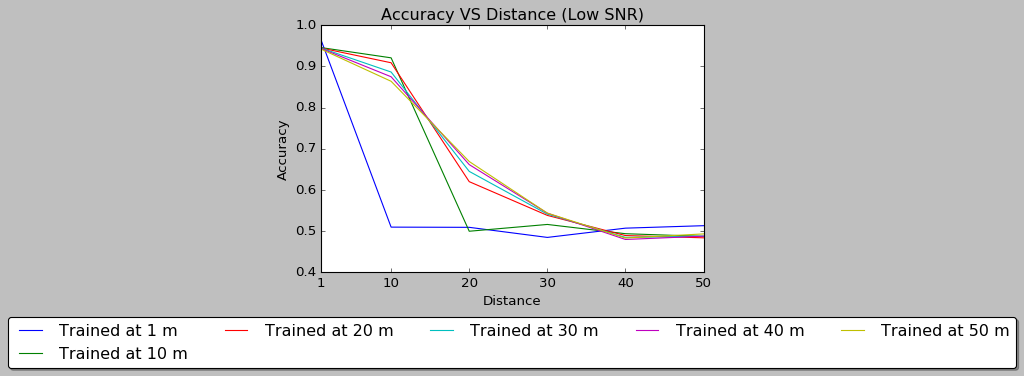

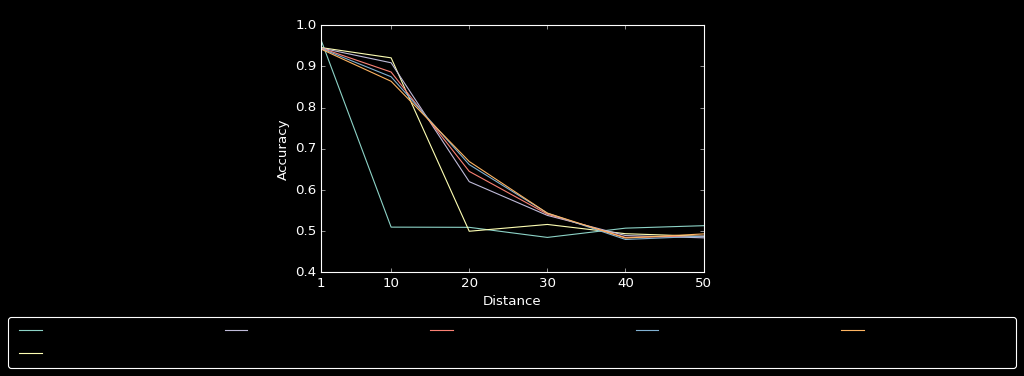

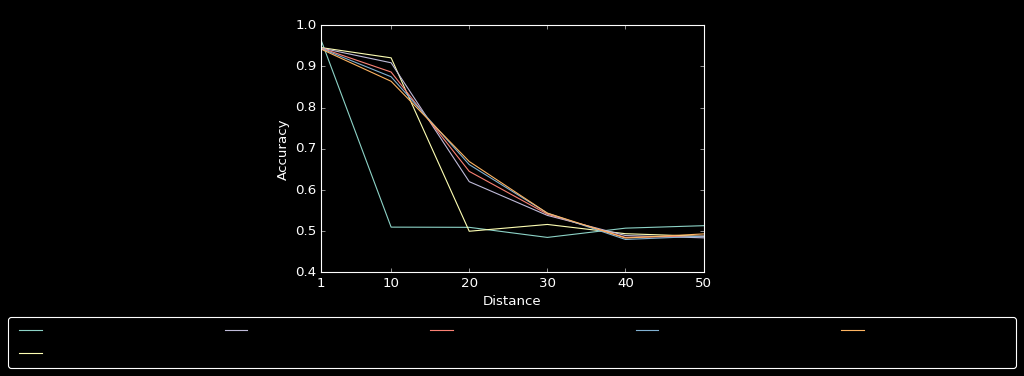

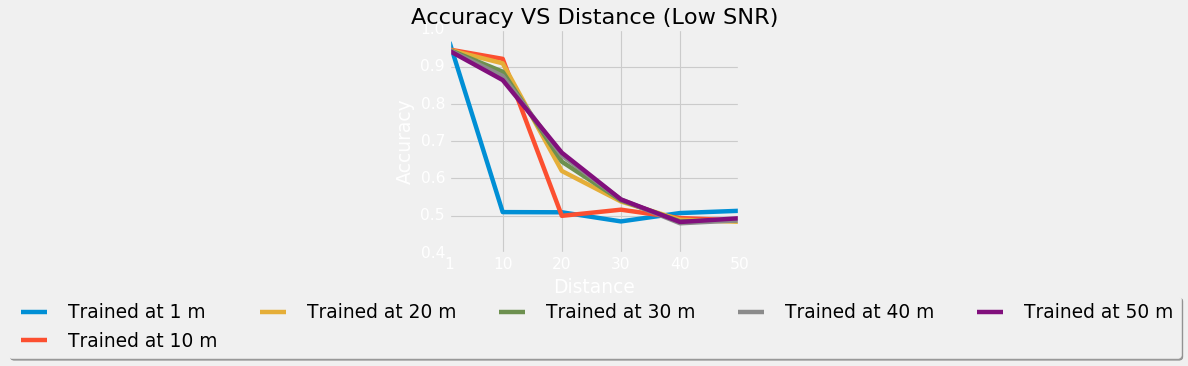

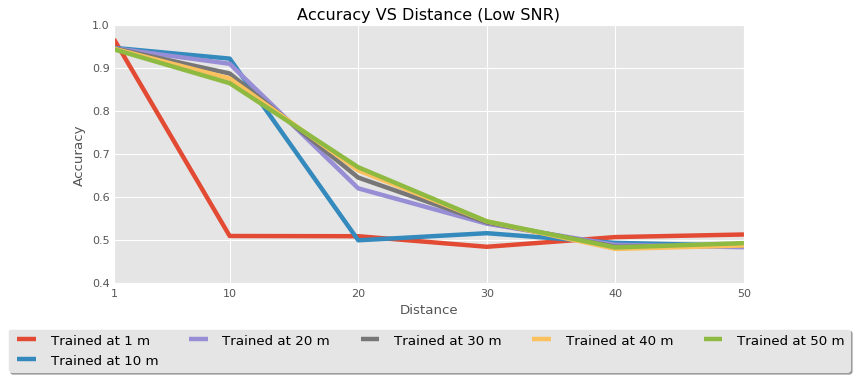

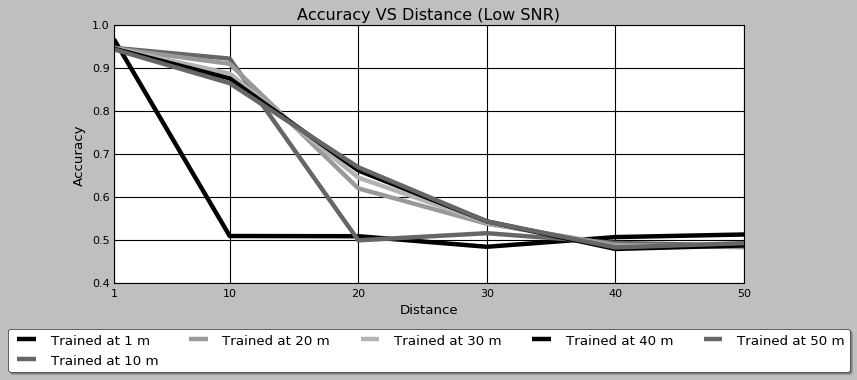

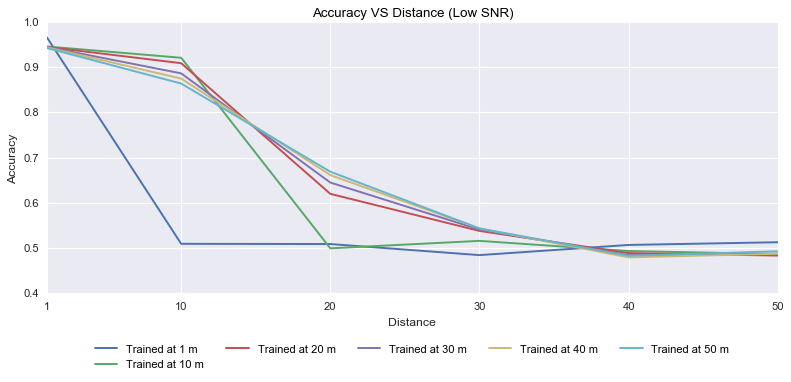

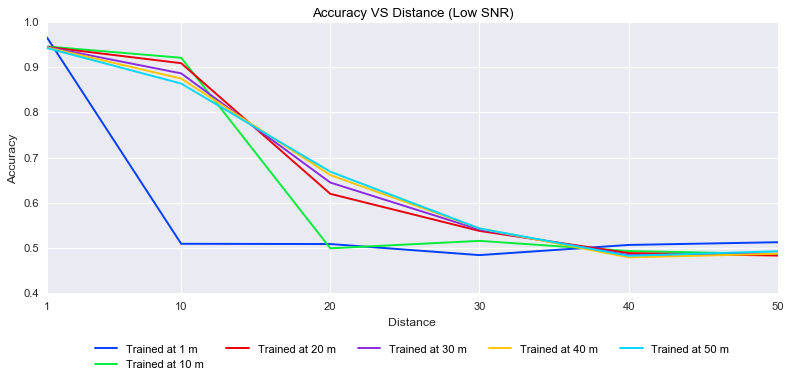

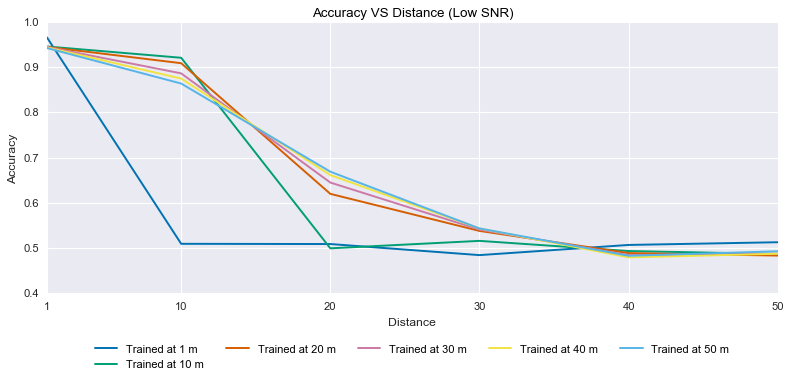

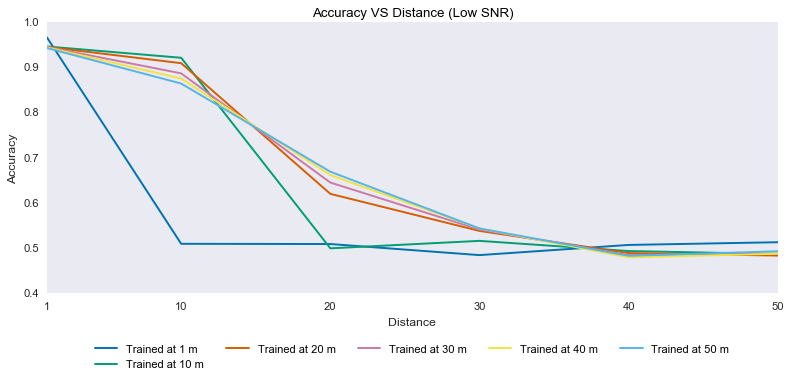

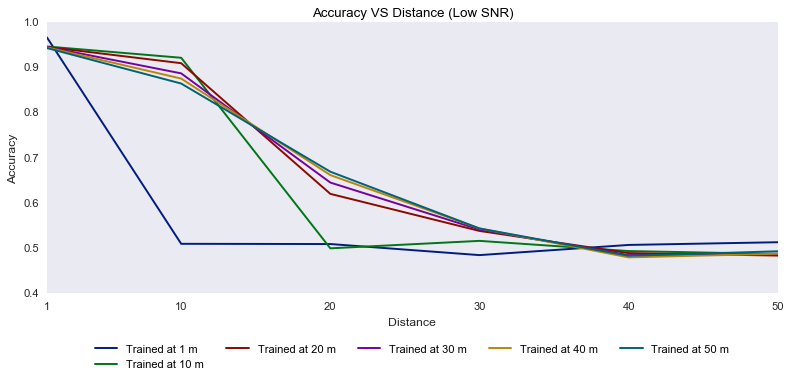

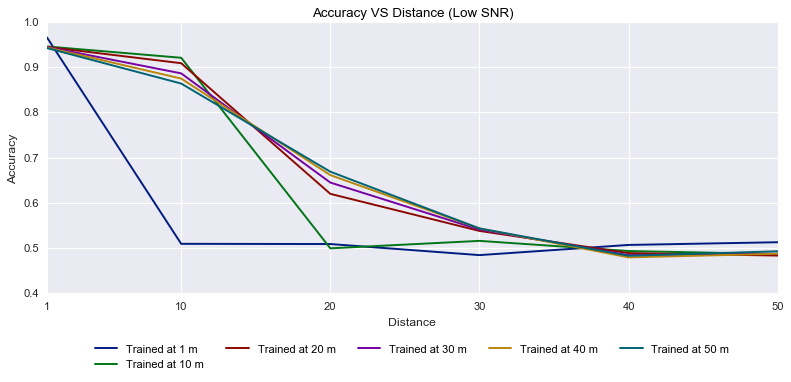

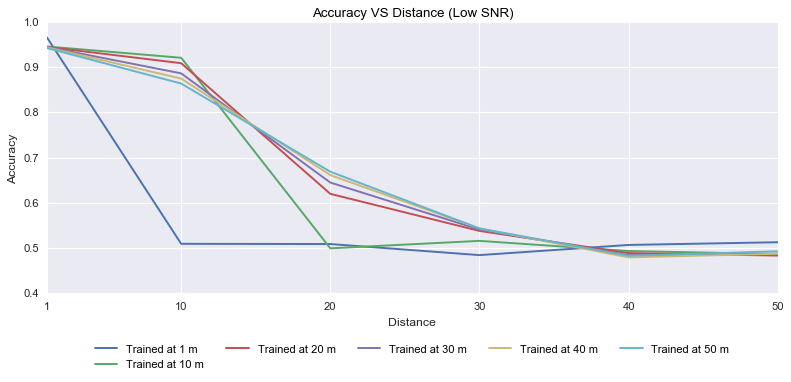

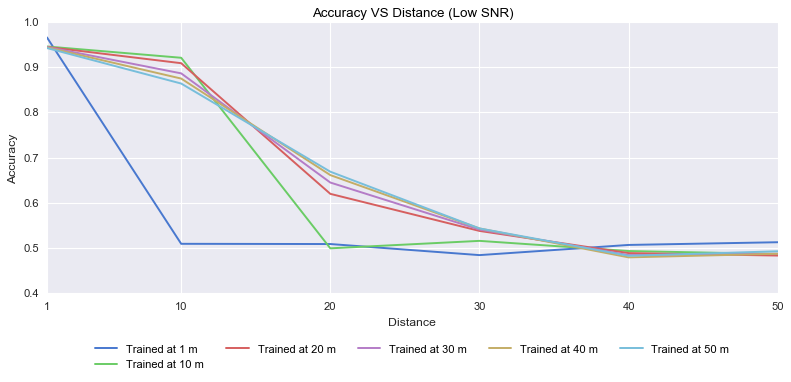

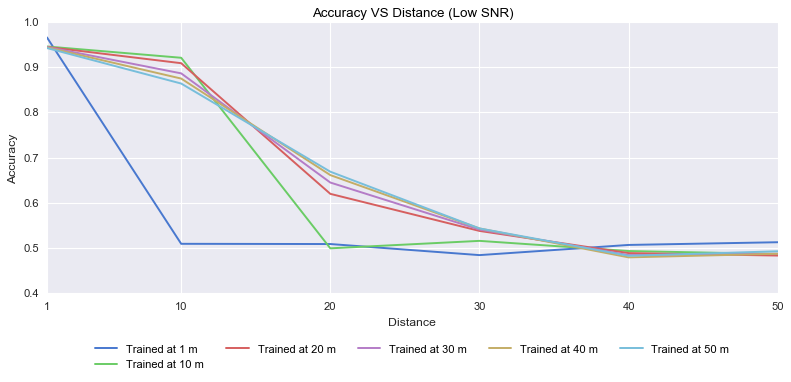

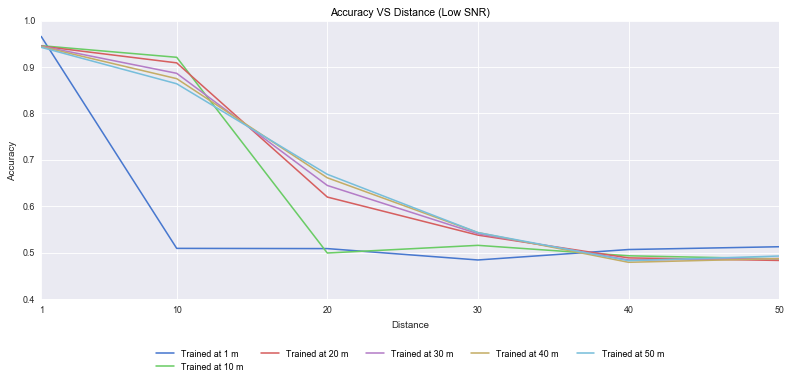

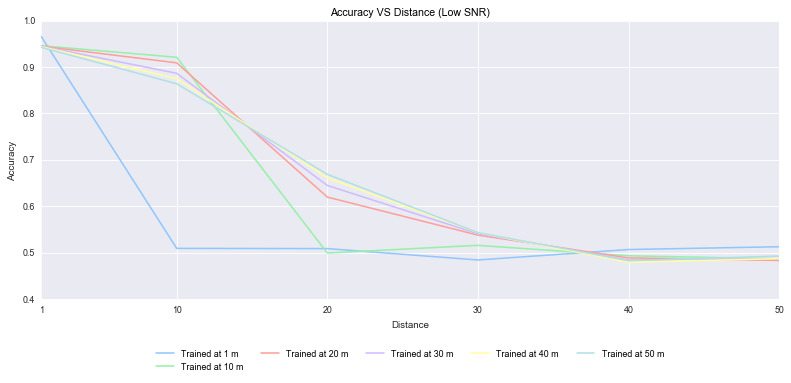

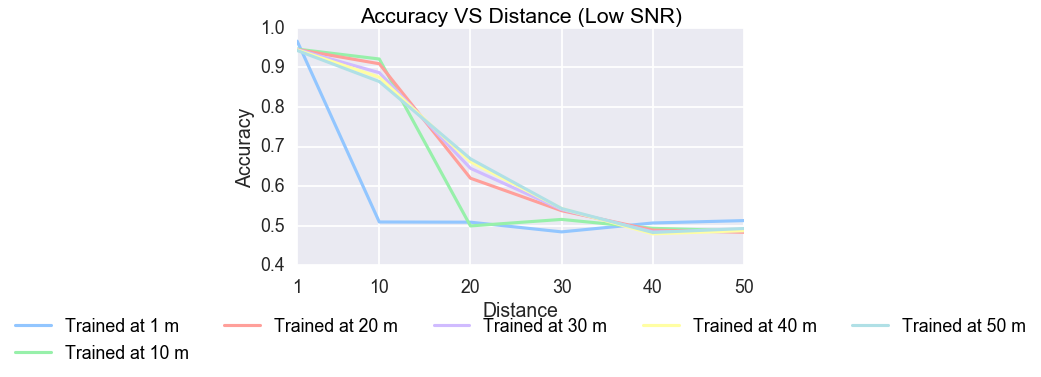

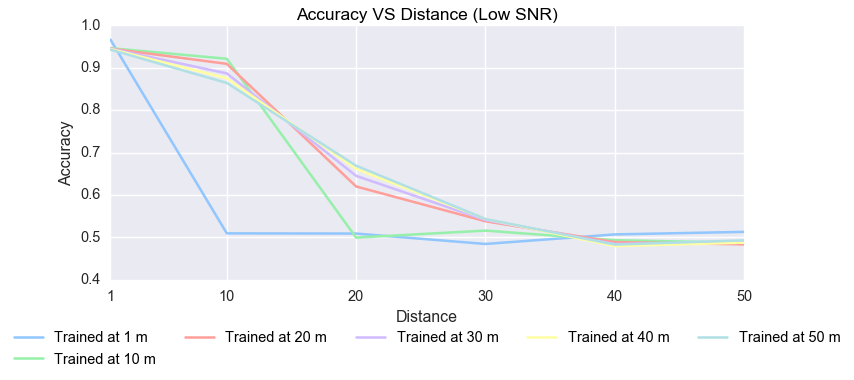

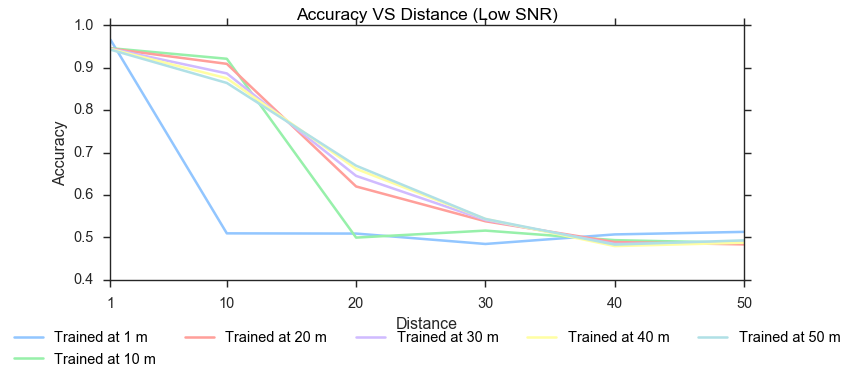

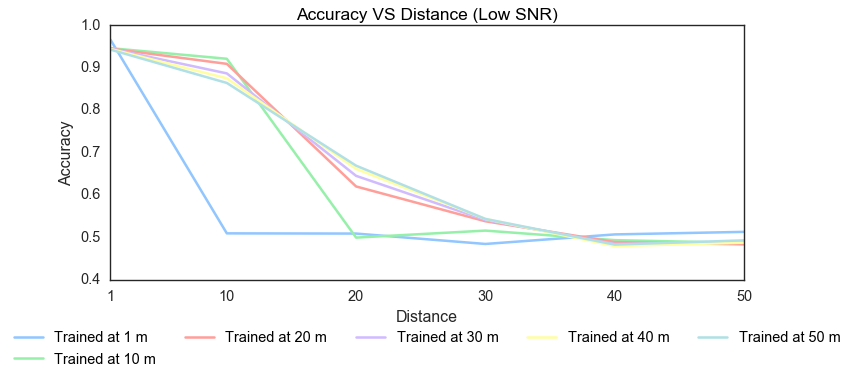

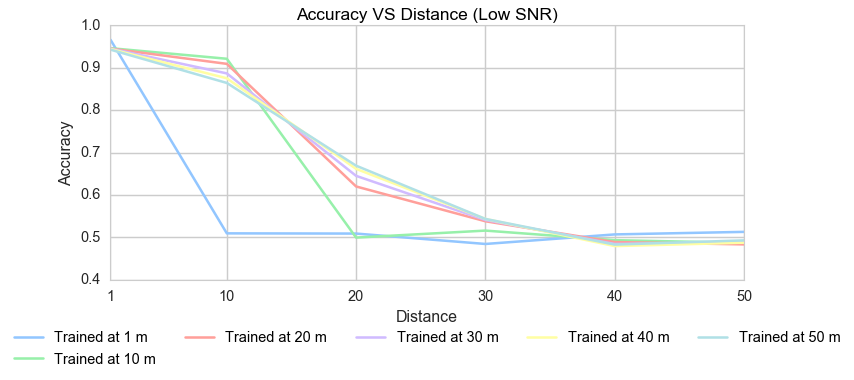

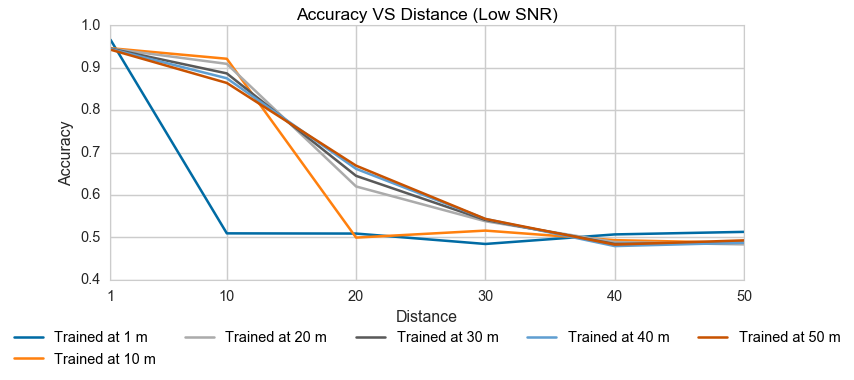

In [21]:
for i in plt.style.available:

    n_curves_per_subplot = 10
    plt.style.use(i)
    n_subplots = (len(RES) + n_curves_per_subplot - 1) // n_curves_per_subplot  
    fig, axes = plt.subplots(nrows=n_subplots, ncols=1, figsize=(10, n_subplots * 5))
    if n_subplots == 1:
        axes = [axes] 

    for j, ax in enumerate(axes):
        start_index = j * n_curves_per_subplot
        end_index = min((j + 1) * n_curves_per_subplot, len(RES))
        for k in range(start_index, end_index):
            ax.plot(ACCORDING_DISTANCES, RES[k], label=f'Trained at {ACCORDING_DISTANCES[k]} m')
        # ax.set_title(f'Subplot {j+1}')
        ax.set_title('Accuracy VS Distance (Low SNR)',color='black')
        ax.set_xlabel('Distance')       
        ax.set_ylabel('Accuracy')
        m = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=5)
        ax.set_xticks(ACCORDING_DISTANCES)
        ax.set_xlim([1, 50])
        for text in m.get_texts():
            text.set_color('black')
    plt.tight_layout()
    plt.show()
